In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

(1, 20)
Mean Euclidean Distance Scores:
Control Group: 21.0179
Exploded Group: 25.0974
Single Dose Group: 12.3809

Dynamic Group Order and Mean Euclidean Distances:
Single Dose Group Mean Euclidean Distance: 12.3809
Control Group Mean Euclidean Distance: 21.0179
Exploded Group Mean Euclidean Distance: 25.0974


C:\Users\k54739\AppData\Local\Temp\ipykernel_9704\2585138519.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

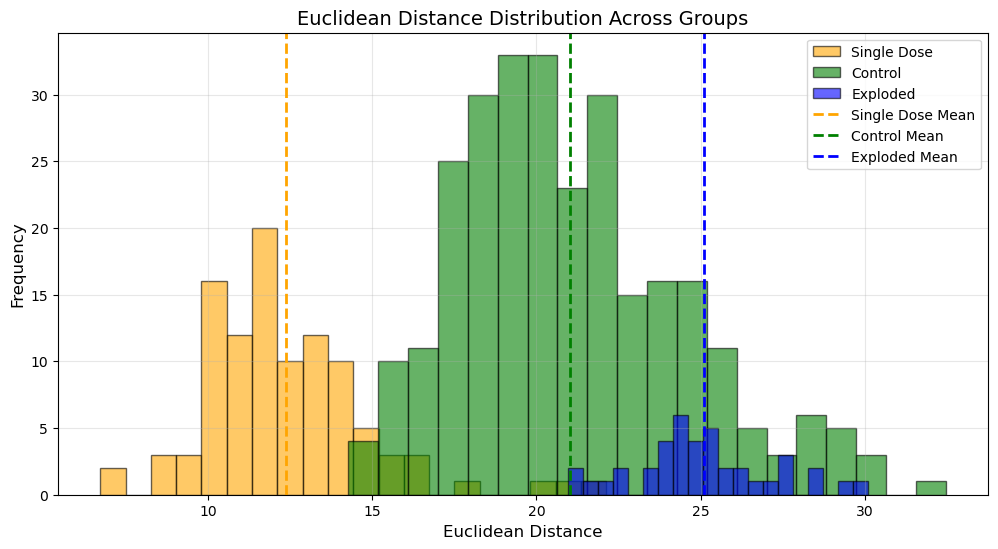


Metrics:
Group-Wise Ranking Accuracy: 0.9005

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


In [2]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

def calculate_and_plot_euclidean_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate Euclidean distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains Euclidean distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    eucli_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np = exp.numpy()
    control_np = control.numpy()
    sd_np = sd.numpy()

    print(eucli_centroid.shape)

    # Calculate Euclidean distances
    control_euclidean_distances = np.linalg.norm(control_np - eucli_centroid, axis=1)
    exp_euclidean_distances = np.linalg.norm(exp_np - eucli_centroid, axis=1)
    sd_euclidean_distances = np.linalg.norm(sd_np - eucli_centroid, axis=1)

    # Calculate mean distances for each group
    mean_control = np.mean(control_euclidean_distances)
    mean_exp = np.mean(exp_euclidean_distances)
    mean_sd = np.mean(sd_euclidean_distances)

    # Print mean scores
    print("Mean Euclidean Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_euclidean_distances, "Control", "green"),
         (mean_exp, exp_euclidean_distances, "Exploded", "blue"),
         (mean_sd, sd_euclidean_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Map labels to the corresponding mean distance
    mean_map = {
        "Control": mean_control,
        "Exploded": mean_exp,
        "Single Dose": mean_sd
    }

    # Print the group order along with the corresponding mean distances
    print("\nDynamic Group Order and Mean Euclidean Distances:")
    for _, _, label, _ in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            print(f"{label} Group Mean Euclidean Distance: {mean_distance:.4f}")
        else:
            print(f"Mean distance not found for {label}")

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Add vertical lines for mean distances
    for _, _, label, color in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            plt.axvline(mean_distance, color=color, linestyle="dashed", linewidth=2, label=f"{label} Mean")

    # Customize plot
    plt.title("Euclidean Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Euclidean Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_euclidean_distances": control_euclidean_distances,
        "exp_euclidean_distances": exp_euclidean_distances,
        "sd_euclidean_distances": sd_euclidean_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined Euclidean distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"ex.pt"
control_save_path_torch = r"cond7.pt"
sd_save_path_torch = r"sd.pt"
eucli_centroid_sd = r"sd.npy"

# Call the function
distances = calculate_and_plot_euclidean_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    eucli_centroid_sd,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


C:\Users\k54739\AppData\Local\Temp\ipykernel_9704\2585138519.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

(1, 20)
Mean Euclidean Distance Scores:
Control Group: 15.4173
Exploded Group: 19.3366
Single Dose Group: 19.0437

Dynamic Group Order and Mean Euclidean Distances:
Control Group Mean Euclidean Distance: 15.4173
Single Dose Group Mean Euclidean Distance: 19.0437
Exploded Group Mean Euclidean Distance: 19.3366


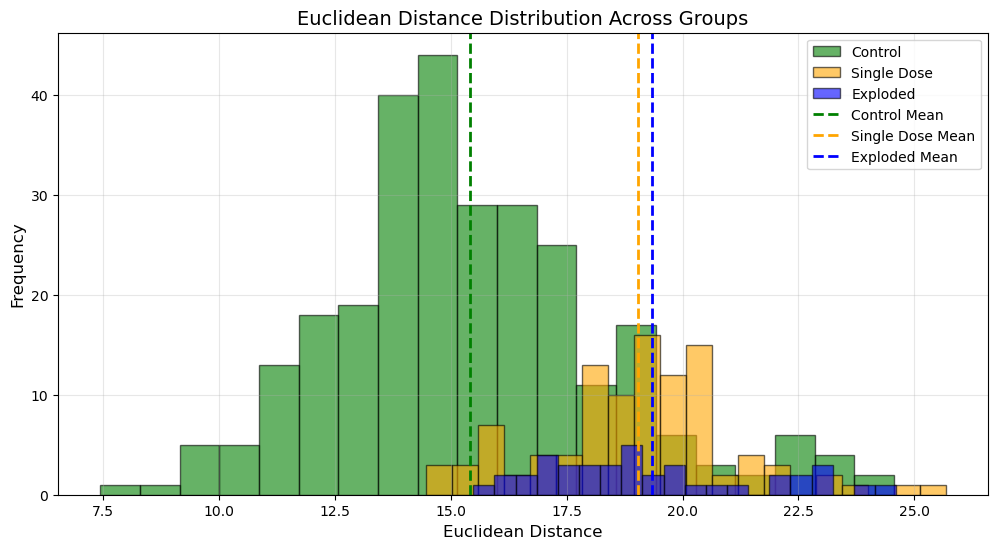


Metrics:
Group-Wise Ranking Accuracy: 0.8223


In [3]:
exp_save_path_torch = r"ex.pt"
control_save_path_torch = r"cond7.pt"
sd_save_path_torch = r"sd.pt"
eucli_centroid_cond7 = r"cond7.npy"
# Call the function
distances = calculate_and_plot_euclidean_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    eucli_centroid_cond7,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]

(1, 20)
Mean Euclidean Distance Scores:
Control Group: 21.6247
Exploded Group: 11.9563
Single Dose Group: 25.2374

Dynamic Group Order and Mean Euclidean Distances:
Exploded Group Mean Euclidean Distance: 11.9563
Control Group Mean Euclidean Distance: 21.6247
Single Dose Group Mean Euclidean Distance: 25.2374


C:\Users\k54739\AppData\Local\Temp\ipykernel_9704\2585138519.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

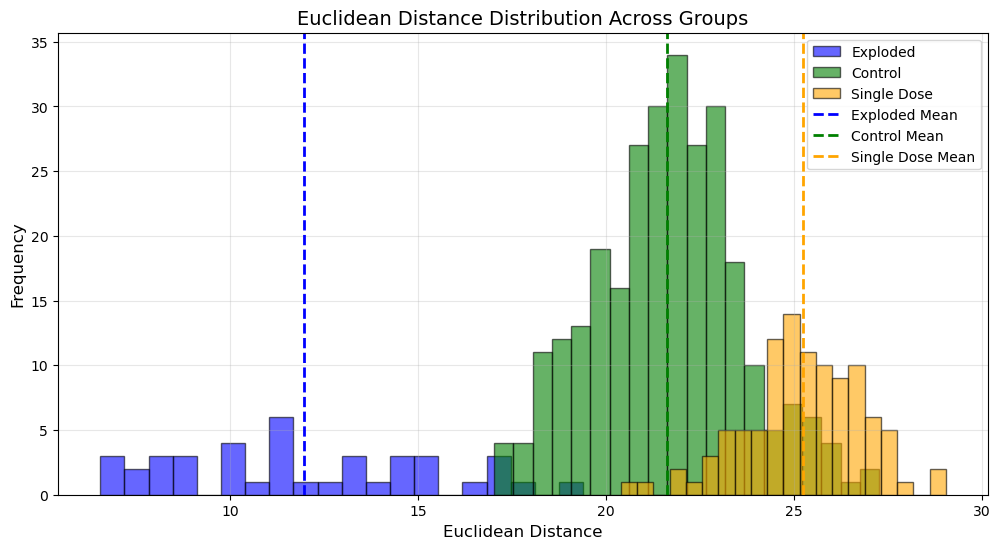


Metrics:
Group-Wise Ranking Accuracy: 0.9052


In [5]:
exp_save_path_torch = r"ex.pt"
control_save_path_torch = r"cond7.pt"
sd_save_path_torch = r"sd.pt"
eucli_centroid_ex = r"ex.npy"
# Call the function
distances = calculate_and_plot_euclidean_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    eucli_centroid_ex,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]

C:\Users\k54739\AppData\Local\Temp\ipykernel_9704\3628948996.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path).numpy()


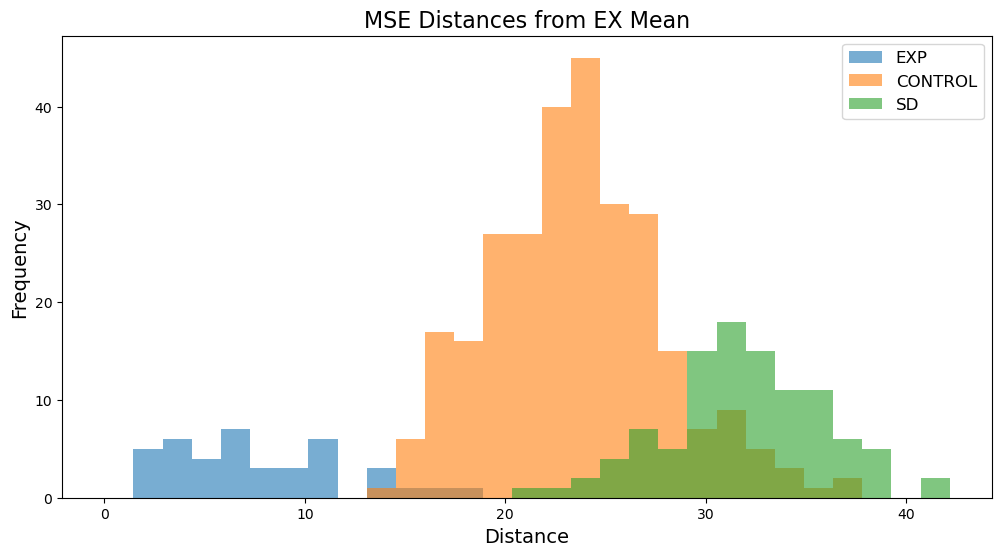

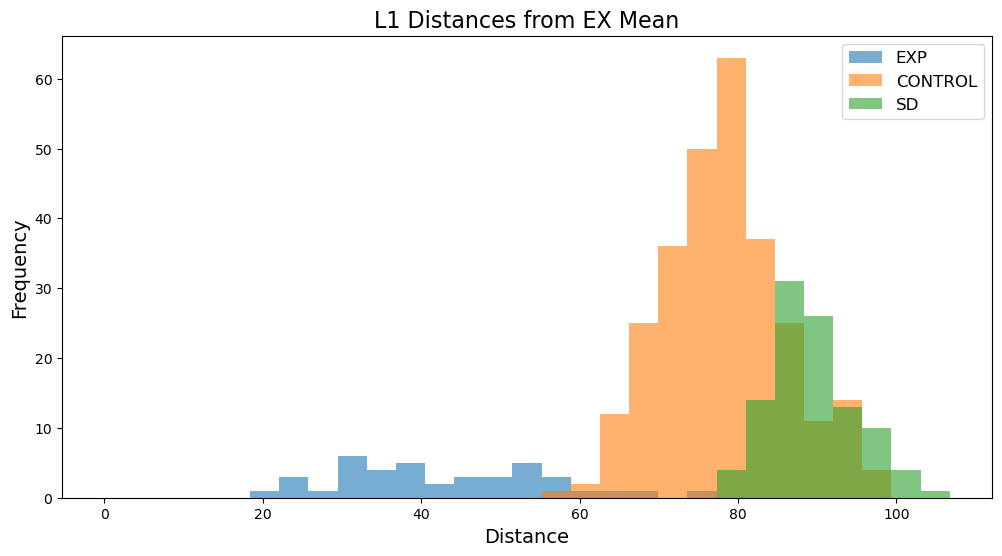

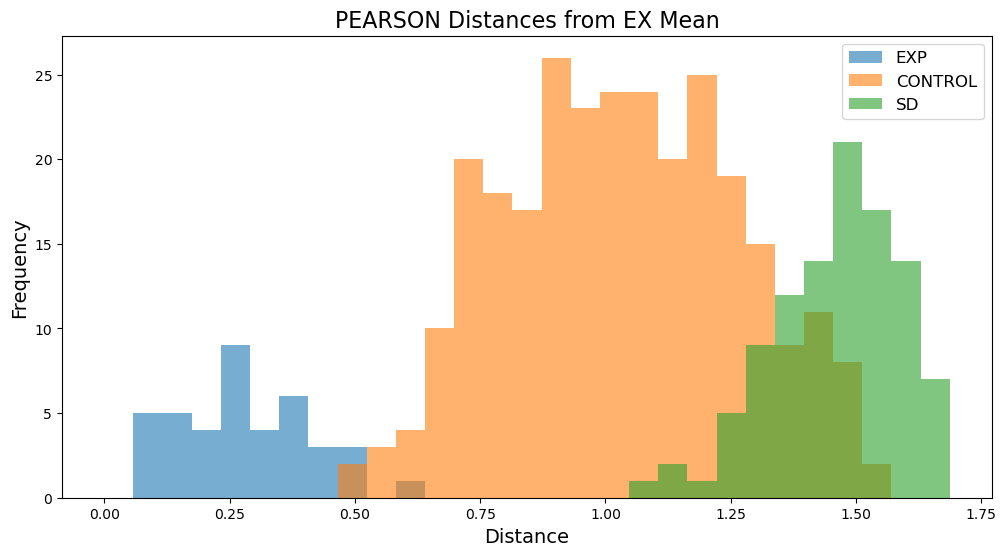

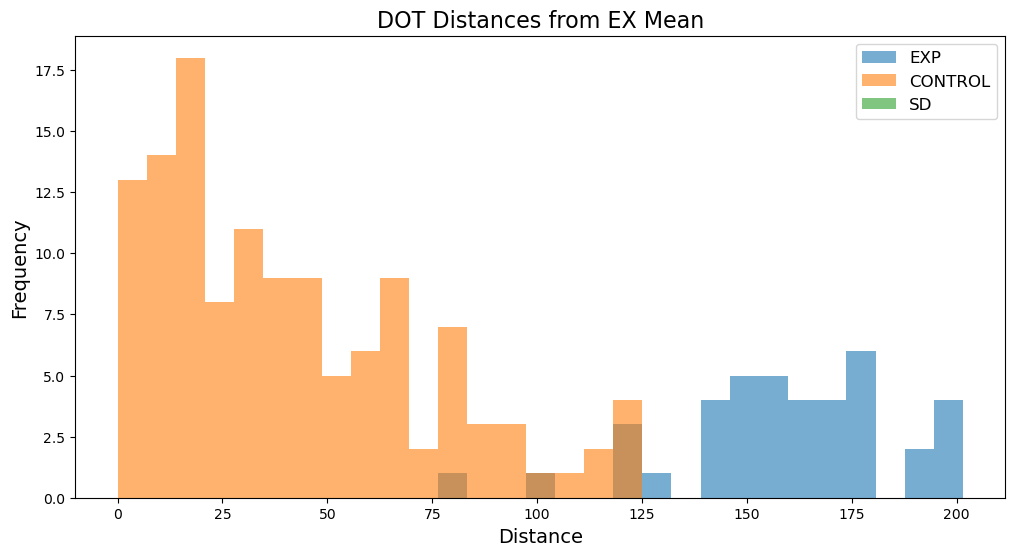

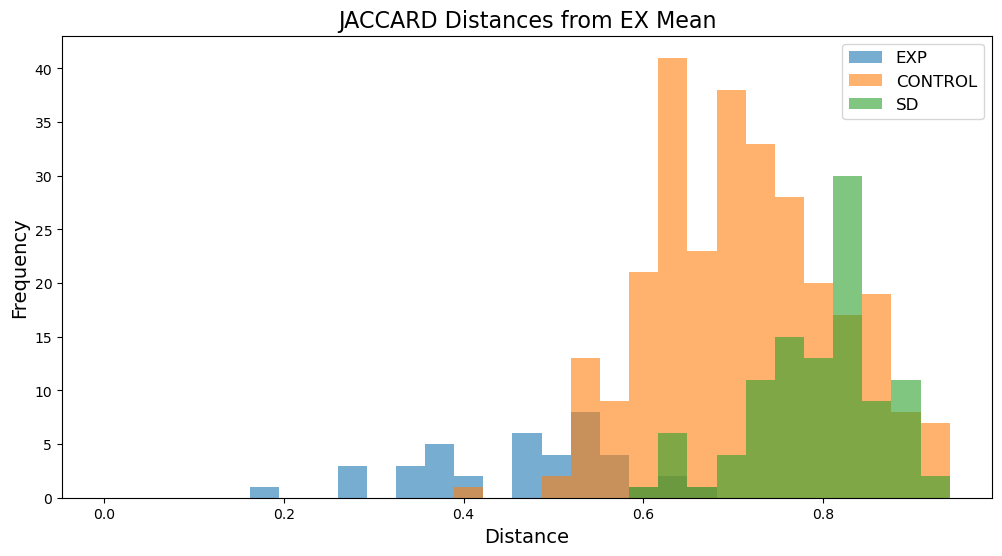

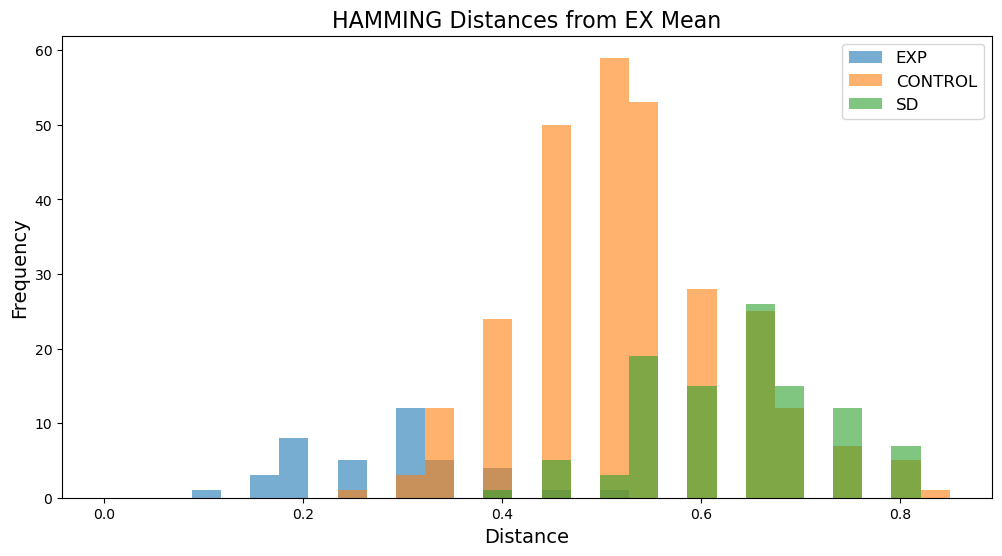

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming, jaccard
from scipy.stats import pearsonr

# Load the feature vectors
def load_group_vectors(path):
    return torch.load(path).numpy()

exp_gp = load_group_vectors(r"ex.pt")
control_gp = load_group_vectors(r"cond7.pt")
sd_gp = load_group_vectors(r"sd.pt")

# Compute ex_mean
ex_mean = np.mean(exp_gp, axis=0)  # Shape: (no_of_features,)

# Function to calculate distances
def calculate_distances(mean_vector, group_vectors, distance_type):
    distances = []
    for vector in group_vectors:
        if distance_type == "mse":
            distances.append(np.mean((mean_vector - vector) ** 2))
        elif distance_type == "l1":
            distances.append(np.sum(np.abs(mean_vector - vector)))
        elif distance_type == "pearson":
            corr, _ = pearsonr(mean_vector, vector)
            distances.append(1 - corr)  # Convert correlation to a distance-like value
        elif distance_type == "dot":
            distances.append(np.dot(mean_vector, vector))
        elif distance_type == "jaccard":
            distances.append(jaccard(mean_vector > 0, vector > 0))  # Binarize for Jaccard
        elif distance_type == "hamming":
            distances.append(hamming(mean_vector > 0, vector > 0))  # Binarize for Hamming
    return distances

# Calculate distances for all groups
def get_group_distances(mean_vector, distance_type):
    return {
        "EXP": calculate_distances(mean_vector, exp_gp, distance_type),
        "CONTROL": calculate_distances(mean_vector, control_gp, distance_type),
        "SD": calculate_distances(mean_vector, sd_gp, distance_type),
    }

# Plot distances
def plot_distances(group_distances, distance_type):
    plt.figure(figsize=(12, 6))
    bins = np.linspace(0, max([max(v) for v in group_distances.values()]), 30)
    
    for group, distances in group_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=group)

    plt.title(f"{distance_type.upper()} Distances from EX Mean", fontsize=16)
    plt.xlabel("Distance", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# Distance types to compute
distance_types = ["mse", "l1", "pearson", "dot", "jaccard", "hamming"]

# Calculate and plot for each distance type
for distance_type in distance_types:
    group_distances = get_group_distances(ex_mean, distance_type)
    plot_distances(group_distances, distance_type)


C:\Users\k54739\AppData\Local\Temp\ipykernel_9704\2210069983.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path).numpy()


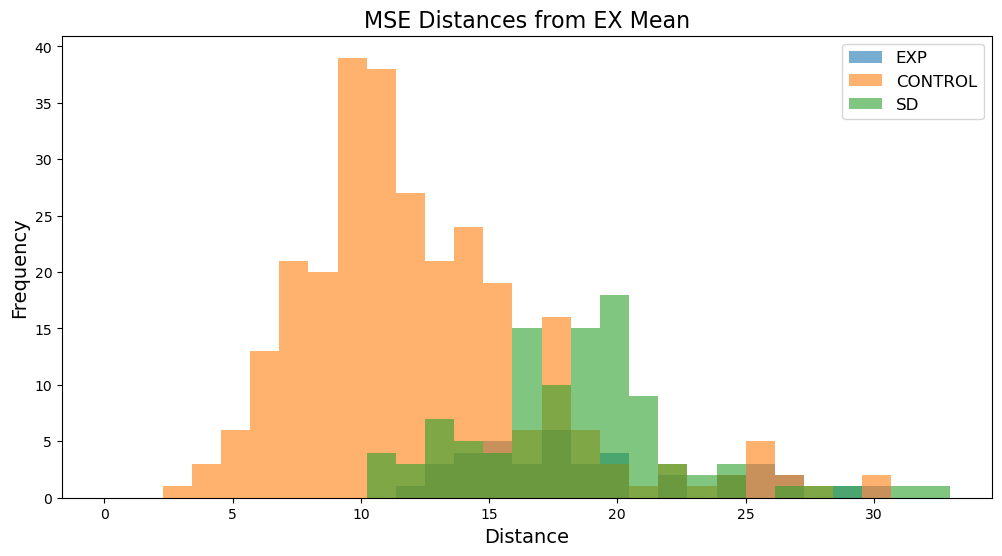

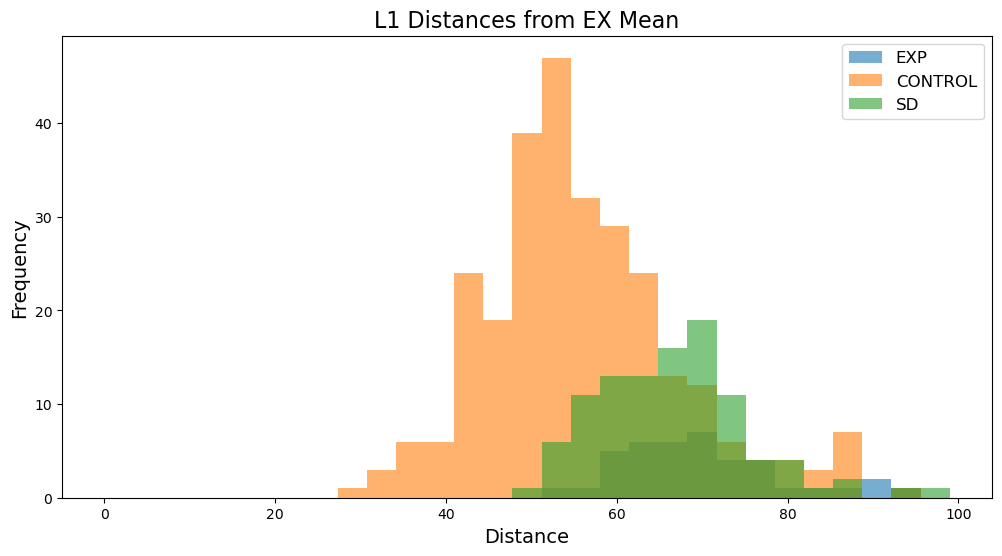

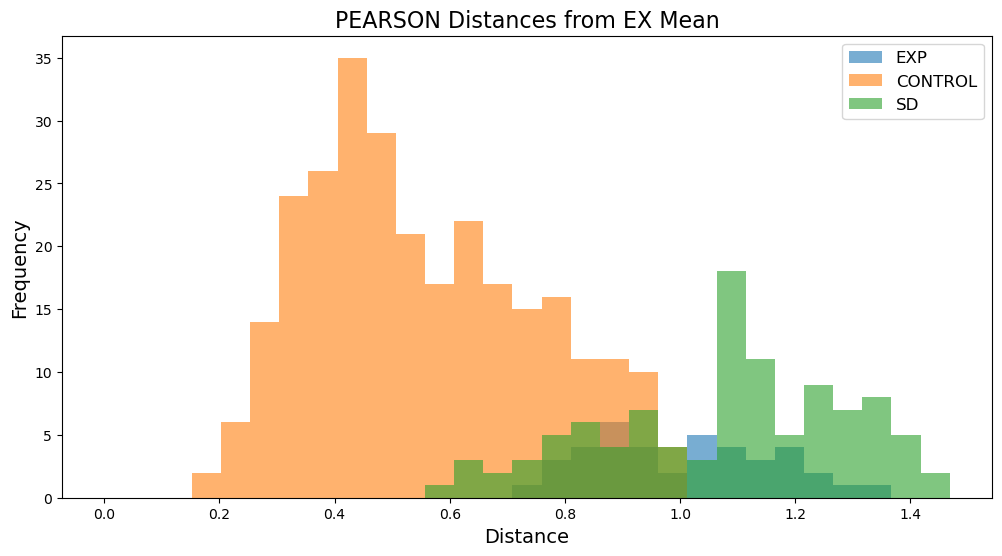

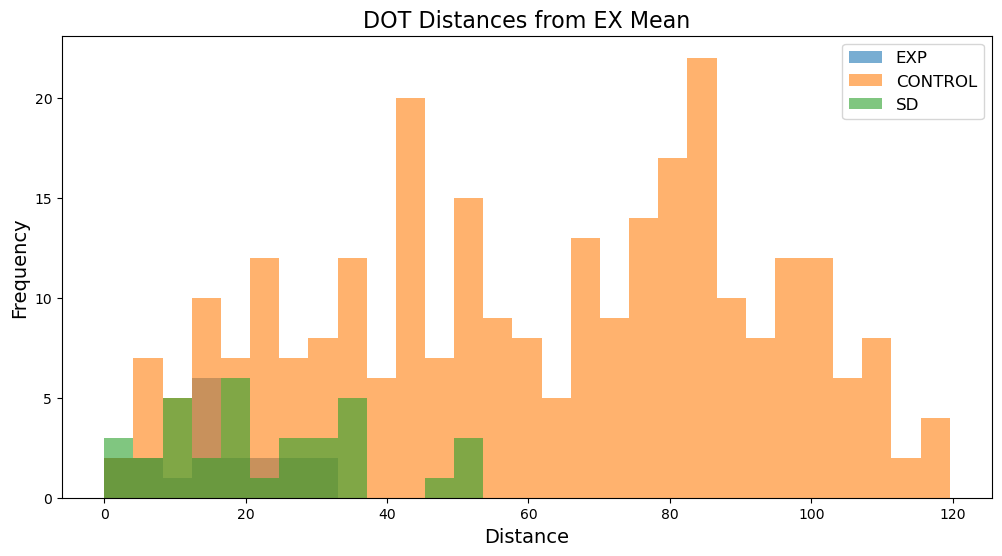

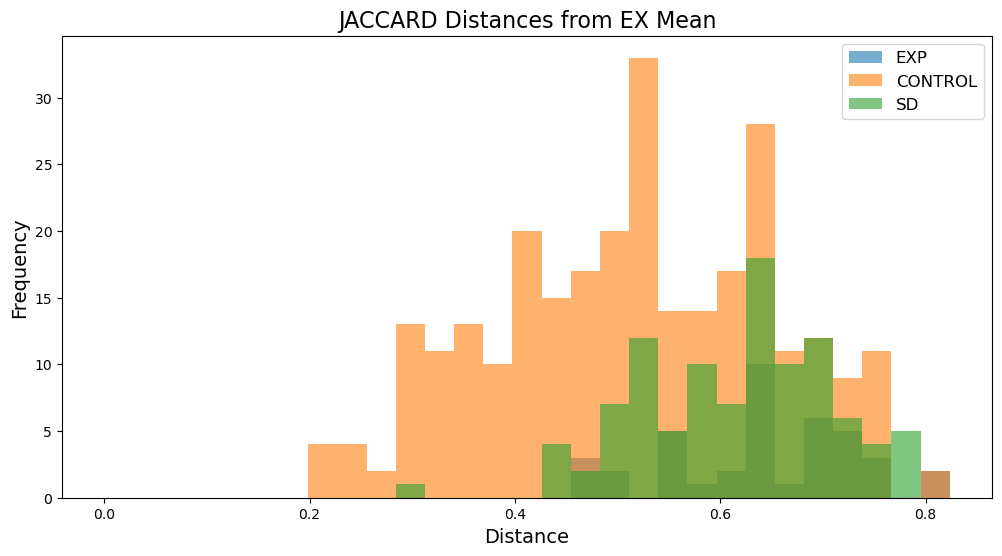

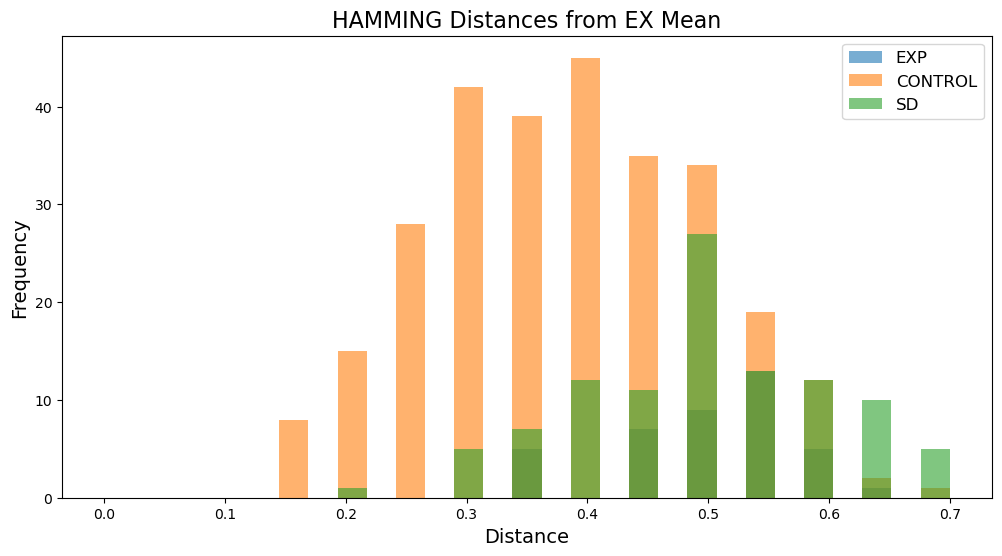

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming, jaccard
from scipy.stats import pearsonr

# Load the feature vectors
def load_group_vectors(path):
    return torch.load(path).numpy()

exp_gp = load_group_vectors(r"ex.pt")
control_gp = load_group_vectors(r"cond7.pt")
sd_gp = load_group_vectors(r"sd.pt")

# Compute ex_mean
mean = np.mean(control_gp, axis=0)  # Shape: (no_of_features,)

# Function to calculate distances
def calculate_distances(mean_vector, group_vectors, distance_type):
    distances = []
    for vector in group_vectors:
        if distance_type == "mse":
            distances.append(np.mean((mean_vector - vector) ** 2))
        elif distance_type == "l1":
            distances.append(np.sum(np.abs(mean_vector - vector)))
        elif distance_type == "pearson":
            corr, _ = pearsonr(mean_vector, vector)
            distances.append(1 - corr)  # Convert correlation to a distance-like value
        elif distance_type == "dot":
            distances.append(np.dot(mean_vector, vector))
        elif distance_type == "jaccard":
            distances.append(jaccard(mean_vector > 0, vector > 0))  # Binarize for Jaccard
        elif distance_type == "hamming":
            distances.append(hamming(mean_vector > 0, vector > 0))  # Binarize for Hamming
    return distances

# Calculate distances for all groups
def get_group_distances(mean_vector, distance_type):
    return {
        "EXP": calculate_distances(mean_vector, exp_gp, distance_type),
        "CONTROL": calculate_distances(mean_vector, control_gp, distance_type),
        "SD": calculate_distances(mean_vector, sd_gp, distance_type),
    }

# Plot distances
def plot_distances(group_distances, distance_type):
    plt.figure(figsize=(12, 6))
    bins = np.linspace(0, max([max(v) for v in group_distances.values()]), 30)
    
    for group, distances in group_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=group)

    plt.title(f"{distance_type.upper()} Distances from EX Mean", fontsize=16)
    plt.xlabel("Distance", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# Distance types to compute
distance_types = ["mse", "l1", "pearson", "dot", "jaccard", "hamming"]

# Calculate and plot for each distance type
for distance_type in distance_types:
    group_distances = get_group_distances(mean, distance_type)
    plot_distances(group_distances, distance_type)


C:\Users\k54739\AppData\Local\Temp\ipykernel_9704\325730274.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path).numpy()


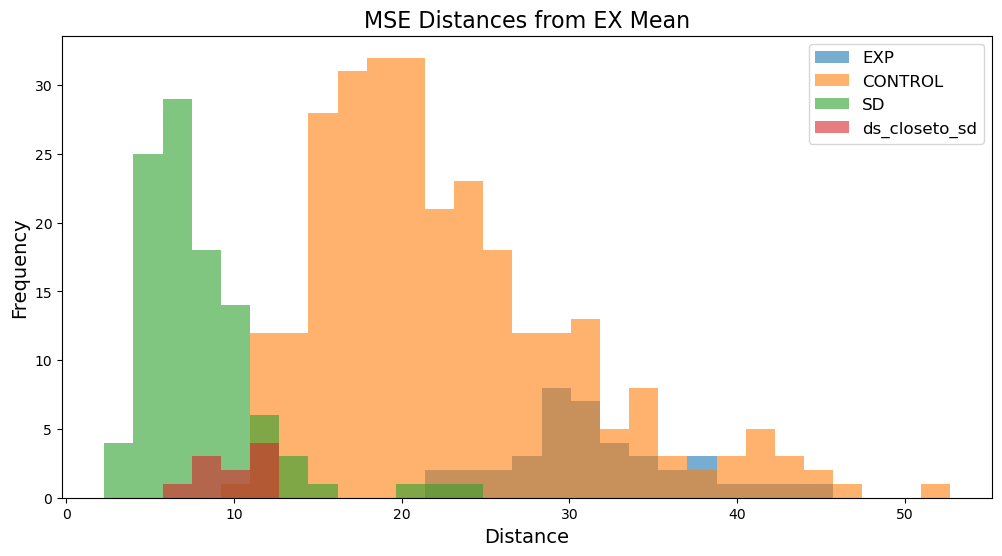

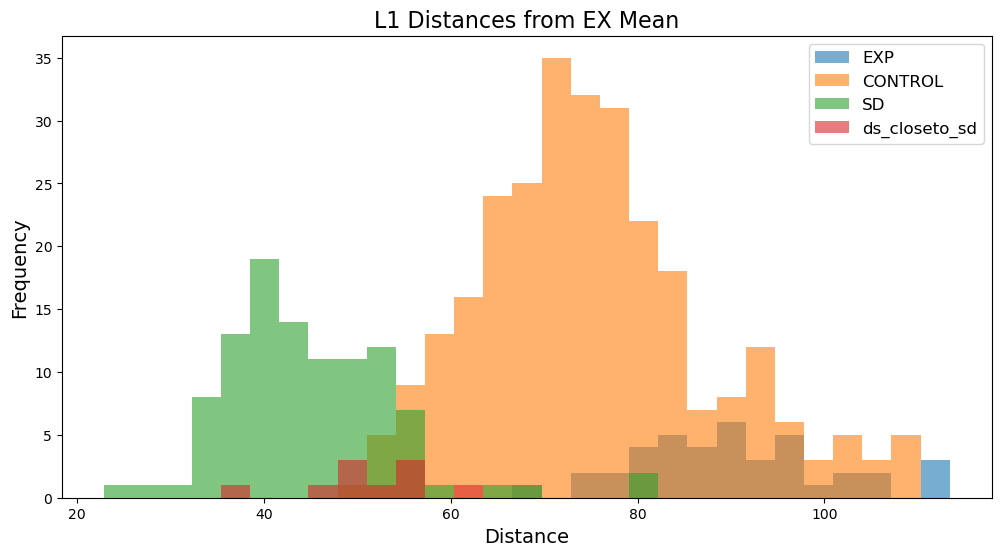

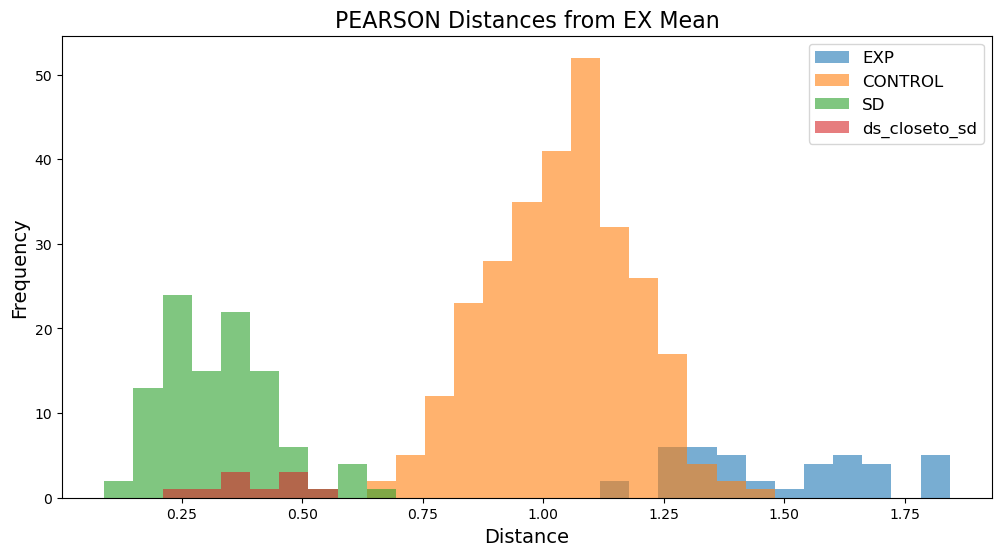

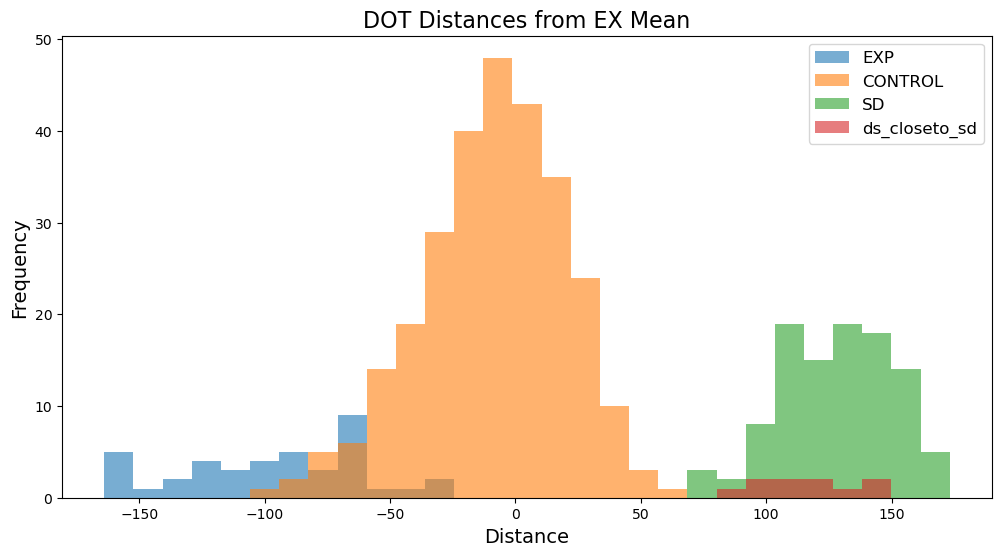

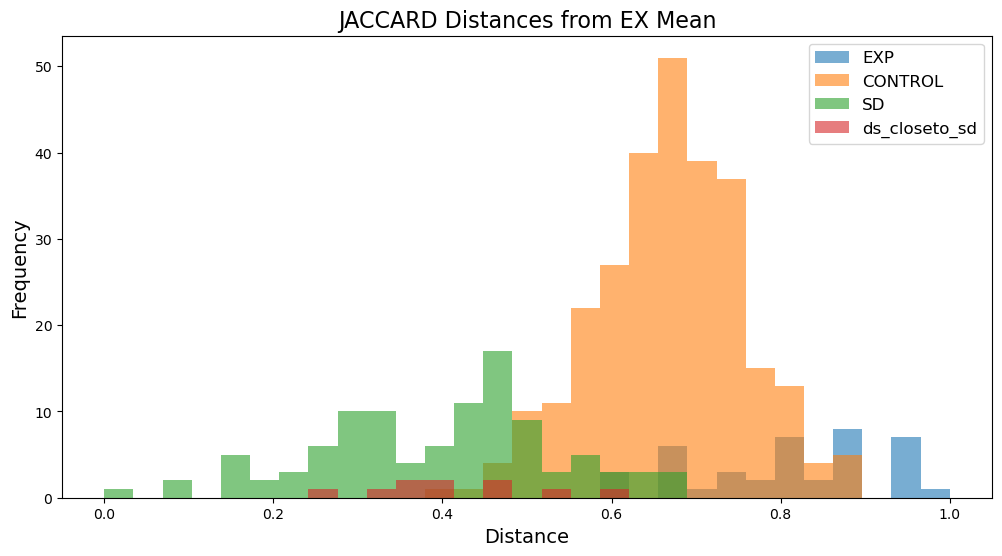

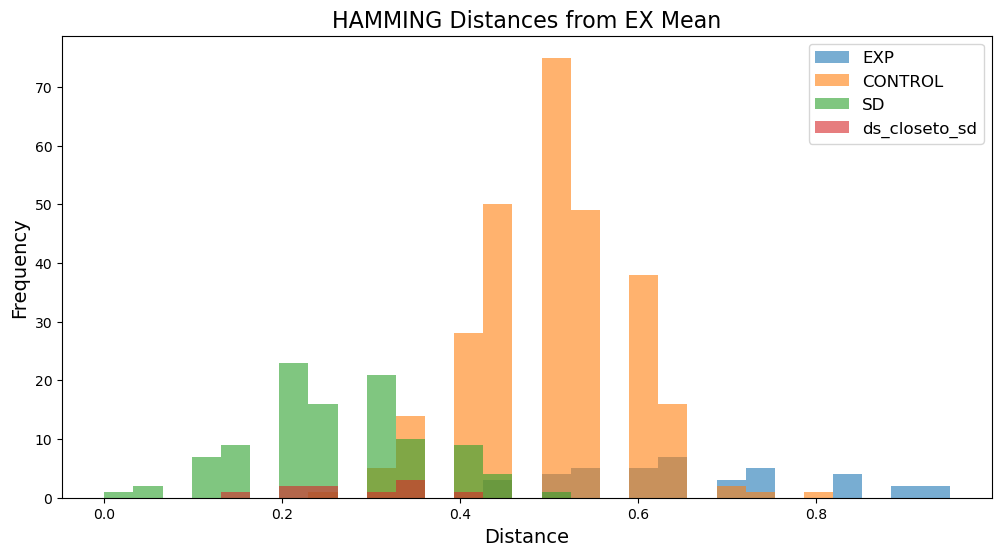

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming, jaccard
from scipy.stats import pearsonr

# Load the feature vectors
def load_group_vectors(path):
    return torch.load(path).numpy()

exp_gp = load_group_vectors(r"ex.pt")
control_gp = load_group_vectors(r"cond7.pt")
sd_gp = load_group_vectors(r"sd.pt")
ds_closeto_sd_gp = load_group_vectors(r"dsclose_worked.pt")

# Compute ex_mean
mean = np.mean(sd_gp, axis=0)  # Shape: (no_of_features,)

# Function to calculate distances
def calculate_distances(mean_vector, group_vectors, distance_type, group_name):
    distances = []
    for vector in group_vectors:
        if distance_type == "mse":
            distances.append(np.mean((mean_vector - vector) ** 2))
        elif distance_type == "l1":
            distances.append(np.sum(np.abs(mean_vector - vector)))
        elif distance_type == "pearson":
            corr, _ = pearsonr(mean_vector, vector)
            distances.append(1 - corr)  # Convert correlation to a distance-like value
        elif distance_type == "dot":
            dot_product = np.dot(mean_vector, vector)
            #print(f"Dot product between SD mean and {group_name} vector: {dot_product}")  # Print dot product with group name
            distances.append(dot_product)
        elif distance_type == "jaccard":
            distances.append(jaccard(mean_vector > 0, vector > 0))  # Binarize for Jaccard
        elif distance_type == "hamming":
            distances.append(hamming(mean_vector > 0, vector > 0))  # Binarize for Hamming
    return distances

# Calculate distances for all groups
def get_group_distances(mean_vector, distance_type):
    return {
        "EXP": calculate_distances(mean_vector, exp_gp, distance_type, "EXP"),
        "CONTROL": calculate_distances(mean_vector, control_gp, distance_type, "CONTROL"),
        "SD": calculate_distances(mean_vector, sd_gp, distance_type, "SD"),
        "ds_closeto_sd":  calculate_distances(mean_vector, ds_closeto_sd_gp, distance_type, "DS")
    }

# Plot distances
# Plot distances
def plot_distances(group_distances, distance_type):
    plt.figure(figsize=(12, 6))
    
    # Ensure bins cover both negative and positive values (adjust the range as needed)
    min_value = min([min(v) for v in group_distances.values()])
    max_value = max([max(v) for v in group_distances.values()])
    bins = np.linspace(min_value, max_value, 30)  # Include negative and positive ranges
    
    for group, distances in group_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=group)

    plt.title(f"{distance_type.upper()} Distances from EX Mean", fontsize=16)
    plt.xlabel("Distance", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# Distance types to compute
distance_types = ["mse", "l1", "pearson", "dot", "jaccard", "hamming"]

# Calculate and plot for each distance type
for distance_type in distance_types:
    group_distances = get_group_distances(mean, distance_type)
    plot_distances(group_distances, distance_type)


C:\Users\k54739\AppData\Local\Temp\ipykernel_20456\880163293.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path).numpy()


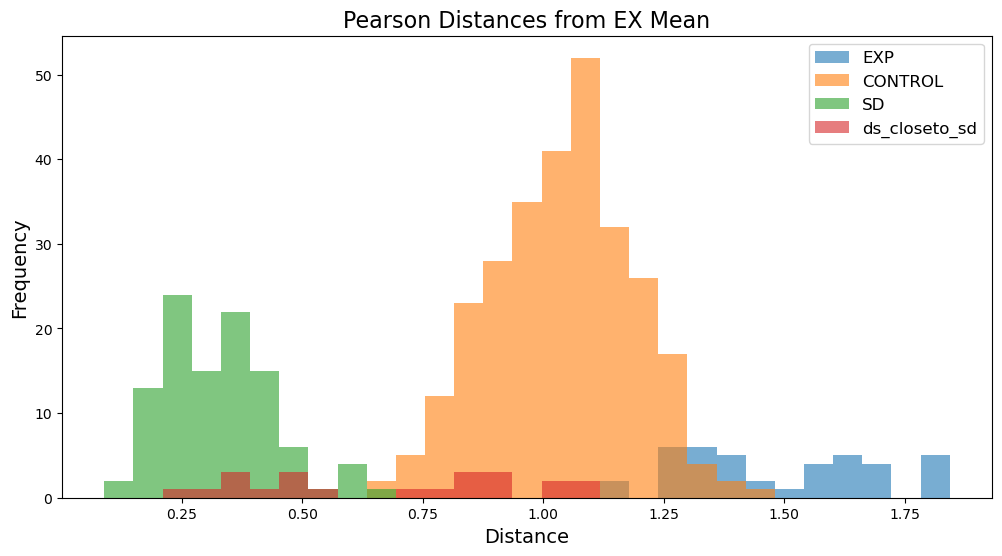

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the feature vectors
def load_group_vectors(path):
    return torch.load(path).numpy()

exp_gp = load_group_vectors(r"ex.pt")
control_gp = load_group_vectors(r"cond7.pt")
sd_gp = load_group_vectors(r"sd.pt")
ds_closeto_sd_gp = load_group_vectors(r"ds_closeto_sd.pt")

# Compute ex_mean
mean = np.mean(sd_gp, axis=0)  # Shape: (no_of_features,)

# Function to calculate Pearson distances
def calculate_pearson_distances(mean_vector, group_vectors, group_name):
    distances = []
    for vector in group_vectors:
        corr, _ = pearsonr(mean_vector, vector)
        distances.append(1 - corr)  # Convert correlation to a distance-like value
    return distances

# Calculate Pearson distances for all groups
def get_group_pearson_distances(mean_vector):
    return {
        "EXP": calculate_pearson_distances(mean_vector, exp_gp, "EXP"),
        "CONTROL": calculate_pearson_distances(mean_vector, control_gp, "CONTROL"),
        "SD": calculate_pearson_distances(mean_vector, sd_gp, "SD"),
        "ds_closeto_sd": calculate_pearson_distances(mean_vector, ds_closeto_sd_gp, "DS")
    }

# Plot Pearson distances
def plot_pearson_distances(group_distances):
    plt.figure(figsize=(12, 6))

    # Ensure bins cover both negative and positive values (adjust the range as needed)
    min_value = min([min(v) for v in group_distances.values()])
    max_value = max([max(v) for v in group_distances.values()])
    bins = np.linspace(min_value, max_value, 30)  # Include negative and positive ranges

    for group, distances in group_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=group)

    plt.title("Pearson Distances from EX Mean", fontsize=16)
    plt.xlabel("Distance", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# Calculate and plot Pearson distances
group_distances = get_group_pearson_distances(mean)
plot_pearson_distances(group_distances)


C:\Users\k54739\AppData\Local\Temp\ipykernel_20456\3245829342.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path).numpy()


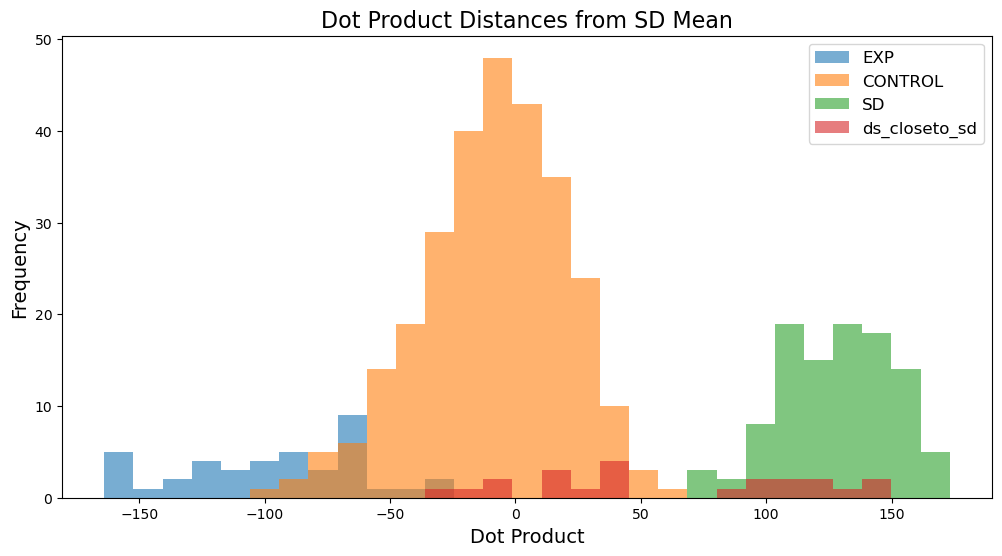

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the feature vectors
def load_group_vectors(path):
    return torch.load(path).numpy()

exp_gp = load_group_vectors(r"ex.pt")
control_gp = load_group_vectors(r"cond7.pt")
sd_gp = load_group_vectors(r"sd.pt")
ds_closeto_sd_gp = load_group_vectors(r"ds_closeto_sd.pt")

# Compute the mean vector
mean = np.mean(sd_gp, axis=0)  # Shape: (no_of_features,)

# Function to calculate dot product distances
def calculate_dot_product_distances(mean_vector, group_vectors, group_name):
    distances = []
    for vector in group_vectors:
        dot_product = np.dot(mean_vector, vector)
        distances.append(dot_product)
    return distances

# Calculate dot product distances for all groups
def get_group_dot_product_distances(mean_vector):
    return {
        "EXP": calculate_dot_product_distances(mean_vector, exp_gp, "EXP"),
        "CONTROL": calculate_dot_product_distances(mean_vector, control_gp, "CONTROL"),
        "SD": calculate_dot_product_distances(mean_vector, sd_gp, "SD"),
        "ds_closeto_sd": calculate_dot_product_distances(mean_vector, ds_closeto_sd_gp, "DS")
    }

# Plot dot product distances
def plot_dot_product_distances(group_distances):
    plt.figure(figsize=(12, 6))

    # Determine the range of bins
    min_value = min([min(v) for v in group_distances.values()])
    max_value = max([max(v) for v in group_distances.values()])
    bins = np.linspace(min_value, max_value, 30)

    for group, distances in group_distances.items():
        plt.hist(distances, bins=bins, alpha=0.6, label=group)

    plt.title("Dot Product Distances from SD Mean", fontsize=16)
    plt.xlabel("Dot Product", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

# Calculate and plot dot product distances
group_distances = get_group_dot_product_distances(mean)
plot_dot_product_distances(group_distances)
